In [22]:
import open3d as o3d
import numpy as np
import copy
import matplotlib.pyplot as plt

np.random.seed(42)
rng = np.random.default_rng(42)

# Функция визуализации (Matplotlib)
def plot_results(pcd_orig, pcd_res, title_orig, title_res):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    for ax, pcd, title in zip([ax1, ax2], [pcd_orig, pcd_res], [title_orig, title_res]):
        pts = np.asarray(pcd.points)
        if pcd.has_normals():
            colors = (np.asarray(pcd.normals) + 1) / 2
            colors = np.clip(colors, 0, 1) 
        else:
            c = pts[:, 2]
            c = (c - c.min()) / (c.max() - c.min()) if c.max() > c.min() else c
            colors = plt.cm.viridis(c)
        
        ax.scatter(pts[:, 0], pts[:, 1], s=0.5, c=colors, alpha=0.5)
        ax.set_title(title)
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.axis('equal')
        ax.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [23]:
# Функция расчета метрик
def calculate_metrics(pcd_gt, pcd_pred):
    d1 = np.asarray(pcd_gt.compute_point_cloud_distance(pcd_pred))
    d2 = np.asarray(pcd_pred.compute_point_cloud_distance(pcd_gt))
    rmse_sym = np.sqrt(0.5 * (np.mean(np.square(d1)) + np.mean(np.square(d2))))
    chamfer_dist = np.mean(np.square(d1)) + np.mean(np.square(d2))
    
    print("="*30)
    print(f"Symmetric RMSE:   {rmse_sym:.6f}")
    print(f"Chamfer Distance: {chamfer_dist:.6f}")
    if rmse_sym < 0.005: grade = "Отлично"
    elif rmse_sym < 0.02: grade = "Хорошо"
    else: grade = "Удовл./Неудовл."
    print(f"Оценка: {grade}")
    print("="*30)

In [24]:
# Генерация данных
def create_composite_object(n_points=100000):
    mesh_sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.5).translate([-0.4, 0, 0])
    mesh_box = o3d.geometry.TriangleMesh.create_box(width=0.8, height=0.8, depth=0.8).translate([0.1, -0.4, -0.4])
    pcd = (mesh_sphere + mesh_box).sample_points_uniformly(number_of_points=n_points)
    
    # Нормализация 
    mins, maxs = np.asarray(pcd.points).min(axis=0), np.asarray(pcd.points).max(axis=0)
    pcd.translate(-pcd.get_center())
    pcd.scale(1.0 / float(np.max(maxs - mins)), center=[0, 0, 0])
    return pcd

pcd_orig = create_composite_object()
pcd_corrupted = copy.deepcopy(pcd_orig)
pts = np.asarray(pcd_corrupted.points)

# Параметры шума
mins, maxs = pts.min(axis=0), pts.max(axis=0)
d = float(np.max(maxs - mins))
sigma = 0.01 * d

# Зашумление
noise = rng.normal(0, sigma, size=pts.shape)
pts_noisy = pts + noise
outliers = rng.uniform(mins - 0.15*d, maxs + 0.15*d, size=(int(0.05*len(pts)), 3))
pts_final = np.vstack([pts_noisy, outliers])

# Добавление NaN
invalid = np.full((int(0.05*len(pts_final)), 3), np.nan)
pcd_corrupted.points = o3d.utility.Vector3dVector(np.vstack([pts_final, invalid]))

print(f"Данные готовы. Исходное: {len(pcd_orig.points)}, Искаженное: {len(pcd_corrupted.points)}")

Данные готовы. Исходное: 100000, Искаженное: 110250


Вариант 1: Voxel Downsample + SOR
Symmetric RMSE:   0.016924
Chamfer Distance: 0.000573
Оценка: Хорошо


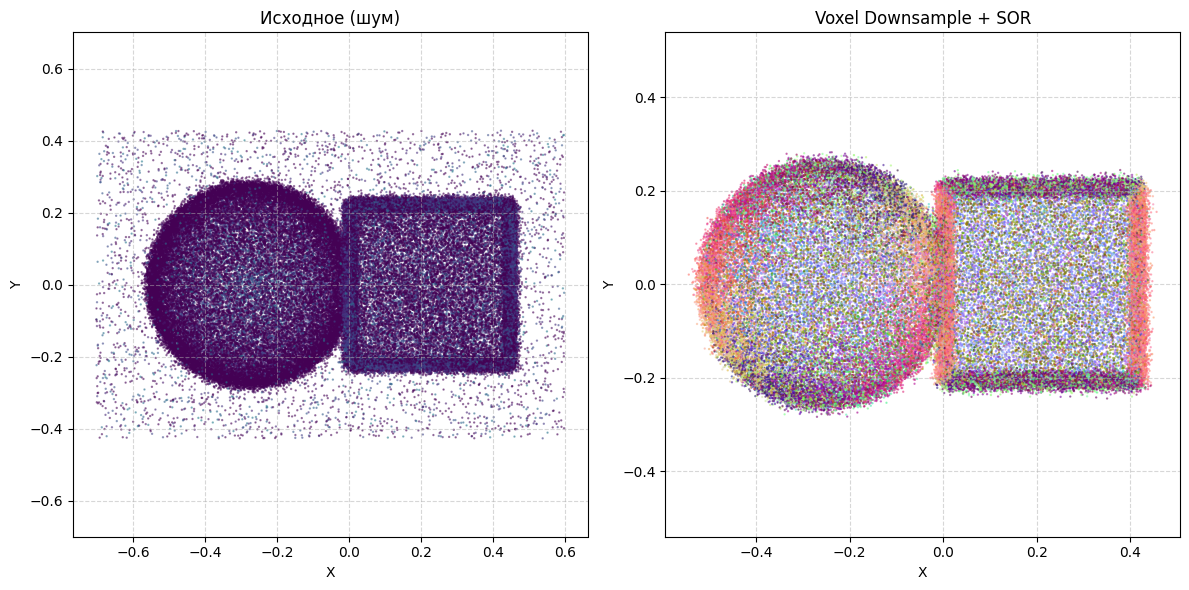

In [25]:
print("Вариант 1: Voxel Downsample + SOR")
pcd_1 = copy.deepcopy(pcd_corrupted)

# Очистка
pcd_1 = pcd_1.remove_non_finite_points(True, True)
pcd_1 = pcd_1.remove_duplicated_points()

# Удаление выбросов (SOR)
_, ind = pcd_1.remove_statistical_outlier(nb_neighbors=50, std_ratio=1.0)
pcd_1 = pcd_1.select_by_index(ind)

# Сглаживание вокселем (0.008 * d)
voxel_size = 0.008 * d
pcd_1 = pcd_1.voxel_down_sample(voxel_size=voxel_size)

# Финальная нормализация
mins, maxs = np.asarray(pcd_1.points).min(axis=0), np.asarray(pcd_1.points).max(axis=0)
pcd_1.translate(-pcd_1.get_center())
pcd_1.scale(1.0 / float(np.max(maxs - mins)), center=[0, 0, 0])

# Оценка нормалей для визуализации
pcd_1.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.05, max_nn=30))

calculate_metrics(pcd_orig, pcd_1)
plot_results(pcd_corrupted, pcd_1, "Исходное (шум)", "Voxel Downsample + SOR")

Вариант 2: Poisson Surface Reconstruction (Depth=7)
Symmetric RMSE:   0.006395
Chamfer Distance: 0.000082
Оценка: Хорошо


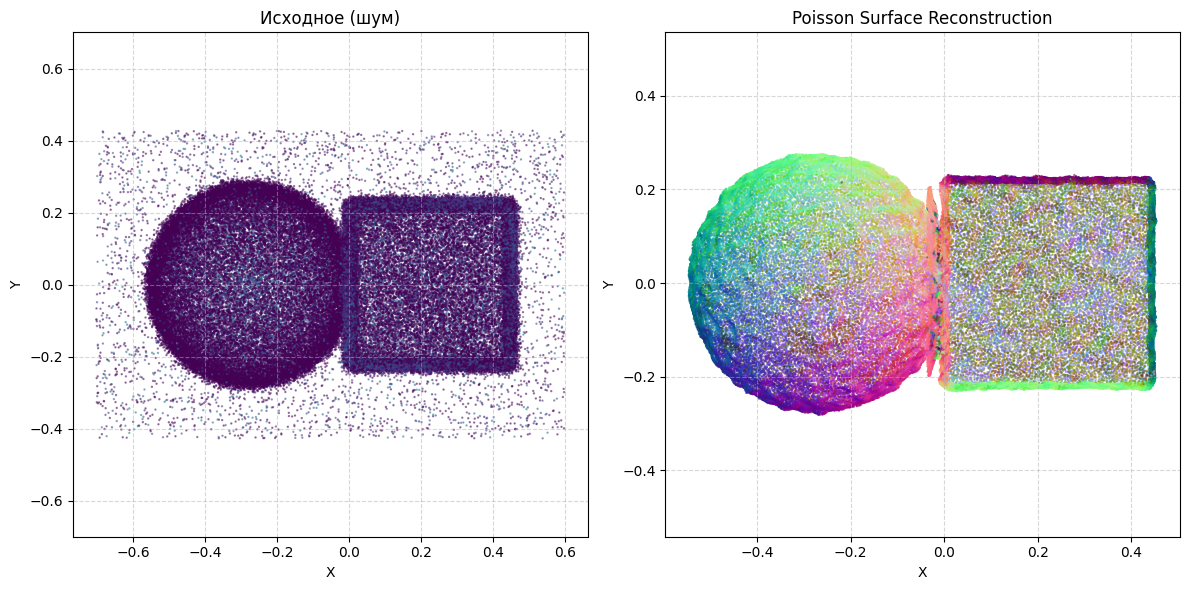

In [26]:
print("Вариант 2: Poisson Surface Reconstruction (Depth=7)")
pcd_2 = copy.deepcopy(pcd_corrupted)

# Строгая очистка (SOR + ROR)
pcd_2 = pcd_2.remove_non_finite_points(True, True)
_, ind = pcd_2.remove_statistical_outlier(nb_neighbors=50, std_ratio=0.8)
pcd_2 = pcd_2.select_by_index(ind)
_, ind = pcd_2.remove_radius_outlier(nb_points=16, radius=0.05)
pcd_2 = pcd_2.select_by_index(ind)

# Нормали 
pcd_2.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.05, max_nn=40))
pcd_2.orient_normals_consistent_tangent_plane(k=40)

# Реконструкция (Мой мак позволяет только Depth=7)
try:
    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
        pcd_2, depth=7, width=0, scale=1.1, linear_fit=False
    )
    # Удаление артефактов
    mesh.remove_vertices_by_mask(densities < np.quantile(densities, 0.05))
    
    # Сэмплинг
    pcd_2 = mesh.sample_points_uniformly(number_of_points=100000)
    
    # Нормализация
    mins, maxs = np.asarray(pcd_2.points).min(axis=0), np.asarray(pcd_2.points).max(axis=0)
    pcd_2.translate(-pcd_2.get_center())
    pcd_2.scale(1.0 / float(np.max(maxs - mins)), center=[0, 0, 0])
    
    # Оценка нормалей для визуализации
    pcd_2.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.05, max_nn=30))
    
    calculate_metrics(pcd_orig, pcd_2)
    plot_results(pcd_corrupted, pcd_2, "Исходное (шум)", "Poisson Surface Reconstruction")

except Exception as e:
    print(f"Ошибка метода Пуассона: {e}")

Вариант 3: Refined BPA + Gentle Smoothing
Symmetric RMSE:   0.013829
Chamfer Distance: 0.000382
Оценка: Хорошо


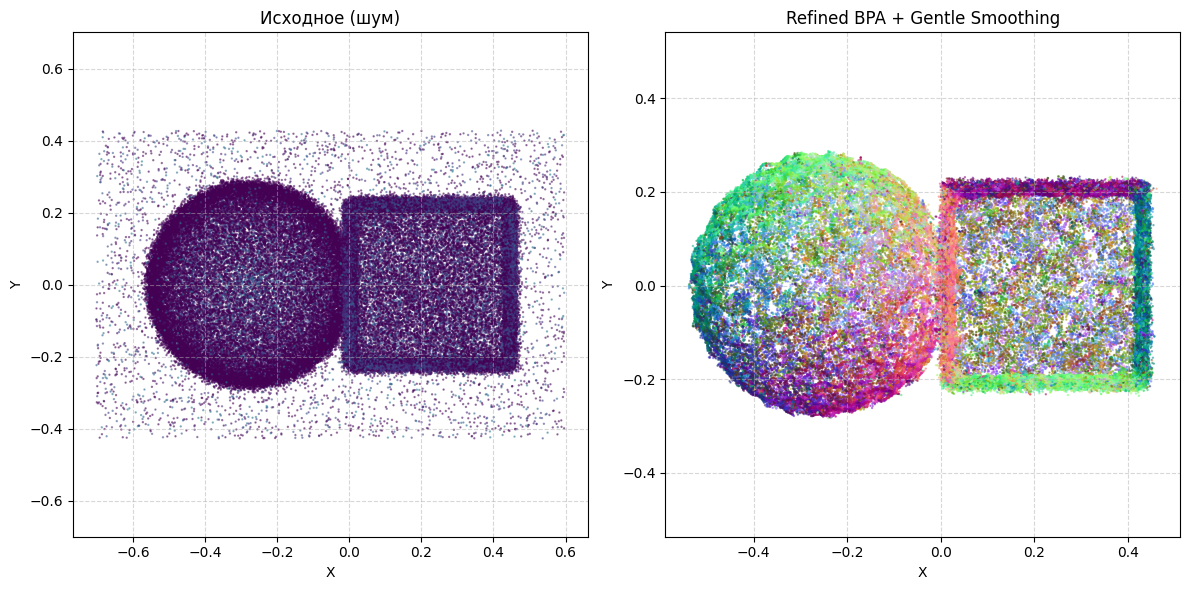

In [27]:
print("Вариант 3: Refined BPA + Gentle Smoothing")
pcd_3 = copy.deepcopy(pcd_corrupted)

# Очистка
pcd_3 = pcd_3.remove_non_finite_points(True, True)
pcd_3 = pcd_3.remove_duplicated_points()

# SOR: фильтр, чтобы убрать шум перед BPA
_, ind = pcd_3.remove_statistical_outlier(nb_neighbors=50, std_ratio=0.8)
pcd_3 = pcd_3.select_by_index(ind)
_, ind = pcd_3.remove_radius_outlier(nb_points=16, radius=0.05)
pcd_3 = pcd_3.select_by_index(ind)

# Вокселизация 
# 0.006 * d, чтобы сохранить углы куба, но усредняя совсем мелкий шум
voxel_size = 0.006 * d
pcd_3 = pcd_3.voxel_down_sample(voxel_size=voxel_size)

# Нормали и BPA
pcd_3.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size*3.0, max_nn=40))
pcd_3.orient_normals_consistent_tangent_plane(k=40)

# Радиусы BPA
radii = [voxel_size * 1.0, voxel_size * 1.5, voxel_size * 2.5]
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
    pcd_3, o3d.utility.DoubleVector(radii)
)

if mesh.has_vertices():
    # Постобработка 
    mesh = mesh.subdivide_midpoint(number_of_iterations=2)
    
    # Сглаживание Таубина
    mesh = mesh.filter_smooth_taubin(number_of_iterations=10)
    
    # Сэмплинг
    pcd_3 = mesh.sample_points_uniformly(number_of_points=100000)
    
    # Нормализация
    mins, maxs = np.asarray(pcd_3.points).min(axis=0), np.asarray(pcd_3.points).max(axis=0)
    pcd_3.translate(-pcd_3.get_center())
    pcd_3.scale(1.0 / float(np.max(maxs - mins)), center=[0, 0, 0])
    
    # Оценка нормалей для красивой картинки
    pcd_3.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.05, max_nn=30))

    calculate_metrics(pcd_orig, pcd_3)
    plot_results(pcd_corrupted, pcd_3, "Исходное (шум)", "Refined BPA + Gentle Smoothing")
else:
    print("BPA не смог построить меш")